# Time Series Prediction with LSTM Using PyTorch

This kernel is based on *datasets* from

[Time Series Forecasting with the Long Short-Term Memory Network in Python](https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/)

[Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)


## Download Dataset

In [1]:
import math
from utils import *

In [2]:
!wget https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv

--2022-05-06 18:26:54--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘raw.githubusercontent.com’


## Library

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

np.random.seed(420)

## Data Plot

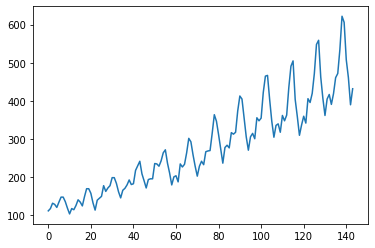

In [4]:
training_set = pd.read_csv('airline-passengers.csv')
#training_set = pd.read_csv('shampoo.csv')

training_set = training_set.iloc[:,1:2].values

#plt.plot(training_set, label = 'Shampoo Sales Data')
plt.plot(training_set, label = 'Airline Passangers Data')
plt.show()

## Dataloading

In [5]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 4
x, y = sliding_windows(training_data, seq_length)

train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [6]:
class CustomLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int, quaternion=False):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz

        if quaternion: linear_layer = QLinear
        else: linear_layer = nn.Linear
        
        #i_t
        self.W_i = linear_layer(input_sz, hidden_sz)
        self.U_i = linear_layer(hidden_sz, hidden_sz, bias=False)
        
        #f_t
        self.W_f = linear_layer(input_sz, hidden_sz)
        self.U_f = linear_layer(hidden_sz, hidden_sz, bias=False)
        
        #c_t
        self.W_c = linear_layer(input_sz, hidden_sz)
        self.U_c = linear_layer(hidden_sz, hidden_sz, bias=False)
        
        #o_t
        self.W_o = linear_layer(input_sz, hidden_sz)
        self.U_o = linear_layer(hidden_sz, hidden_sz, bias=False)
        
        self.init_weights()
    
    def init_weights(self):
        stdv = 1.0 / math.sqrt(self.hidden_size)
        for weight in self.parameters():
            weight.data.uniform_(-stdv, stdv)
    
    def forward(self, x, init_states=None):
        """
        x.shape == (batch_size, sequence_size, input_size)
        """
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        
        if init_states is None:
            h_t, c_t = (
                torch.zeros(bs, self.hidden_size),
                torch.zeros(bs, self.hidden_size),
            )
        else:
            h_t, c_t = init_states
            
        for t in range(seq_sz):
            x_t = x[:, t, :]
            i_t = torch.sigmoid(self.W_i(x_t) + self.U_i(h_t))
            f_t = torch.sigmoid(self.W_f(x_t) + self.U_f(h_t))
            g_t = torch.tanh(self.W_c(x_t) + self.U_c(h_t))
            o_t = torch.sigmoid(self.W_o(x_t) + self.U_o(h_t))
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)    
            hidden_seq.append(h_t.unsqueeze(0))
        
        hidden_seq = torch.cat(hidden_seq, dim=0)
        hidden_seq = hidden_seq.transpose(0, 1).contiguous()
        return hidden_seq, (h_t, c_t)

In [7]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        # self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
        #                     num_layers=num_layers, batch_first=True)
        self.lstm = CustomLSTM(input_sz=input_size, hidden_sz=hidden_size, quaternion=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))

        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [8]:
num_epochs = 2001
learning_rate = 0.01

input_size = 4
hidden_size = 8
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    inputs = torch.cat((trainX, trainX, trainX, trainX), dim=2)
    outputs = lstm(inputs)
    optimizer.zero_grad()
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.26955
Epoch: 100, loss: 0.00281
Epoch: 200, loss: 0.00227
Epoch: 300, loss: 0.00201
Epoch: 400, loss: 0.00187
Epoch: 500, loss: 0.00176
Epoch: 600, loss: 0.00170
Epoch: 700, loss: 0.00167
Epoch: 800, loss: 0.00165
Epoch: 900, loss: 0.00164
Epoch: 1000, loss: 0.00163
Epoch: 1100, loss: 0.00162
Epoch: 1200, loss: 0.00161
Epoch: 1300, loss: 0.00160
Epoch: 1400, loss: 0.00159
Epoch: 1500, loss: 0.00159
Epoch: 1600, loss: 0.00158
Epoch: 1700, loss: 0.00157
Epoch: 1800, loss: 0.00156
Epoch: 1900, loss: 0.00155
Epoch: 2000, loss: 0.00155


## Testing for Airplane Passengers Dataset

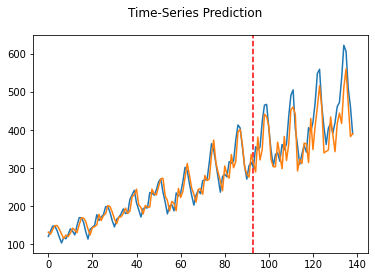

In [9]:
lstm.eval()
inputs = torch.cat((dataX, dataX, dataX, dataX), dim=2)
train_predict = lstm(inputs)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()